In [1]:
!pip install stable-baselines3==2.1.0
!pip install shimmy==0.2.1
!pip install --no-deps simplejson
!pip install shap
!pip install --no-deps citylearn==1.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 947.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
# system files
import sys, os

# type hinting
from typing import List, Mapping
from ipywidgets import IntProgress, VBox, HTML

# Data visualization
import time
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from copy import deepcopy

# CityLearn
from citylearn.agents.rbc import HourRBC
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

# custom modules (場所を取ってしまうので、関数は別ファイルにコピー)
cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'
sys.path.append(os.path.join(cwd))
from preprocessing import set_schema_buildings, set_schema_simulation_period, set_active_observations, get_timestep
from plot_kpi import plot_simulation_summary, plot_actions, plot_rewards

%matplotlib inline

# Suppress DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [44]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

root_directory = schema['root_directory']

In [45]:
BUILDING_INDEX = [7]

schema, buildings = set_schema_buildings(schema, BUILDING_INDEX)
print('Selected buildings:', buildings)

Selected buildings: ['Building_7']


In [46]:
pricing_obs = ['electricity_pricing',
               'electricity_pricing_predicted_6h',
               'electricity_pricing_predicted_12h',
               'electricity_pricing_predicted_24h']

# set pricing obervation to shared
for ob in pricing_obs:
    schema["observations"][ob]['shared_in_central_agent']=True

schema['central_agent'] = True

In [47]:
# Analysis Timestep
START = get_timestep(6,5,0)
STOP = get_timestep(6,12,23)

schema = set_schema_simulation_period(schema,
                                      START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (7392, 7583)


In [48]:
rbc_schema = deepcopy(schema)

ACTIVE_OBSERVATIONS = [
                       'hour',
                       ]

rbc_schema = set_active_observations(rbc_schema, ACTIVE_OBSERVATIONS)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Active observations: ['hour']


In [49]:
# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = [
                       'month',
                       'day_type',
                       'hour',
                    #    'diffuse_solar_irradiance',
                    #    'diffuse_solar_irradiance_predicted_6h',
                    #    'diffuse_solar_irradiance_predicted_12h',
                    #    'direct_solar_irradiance',
                    #    'direct_solar_irradiance_predicted_6h',
                    #    'direct_solar_irradiance_predicted_12h',
                       'carbon_intensity',
                       'non_shiftable_load',
                       'solar_generation',
                       'electrical_storage_soc',
                       'electricity_pricing',
                       'electricity_pricing_predicted_6h',
                       'electricity_pricing_predicted_12h',
                       ]

schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

print(f'Active observations:', ACTIVE_OBSERVATIONS)

Active observations: ['month', 'day_type', 'hour', 'carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc', 'electricity_pricing', 'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h']


In [50]:
training_schema = deepcopy(schema)

# Testing timestep
START = get_timestep(8,1,0)
STOP = get_timestep(5,31,23)

training_schema = set_schema_simulation_period(training_schema,
                                      START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (0, 7295)


In [51]:
rbc_env = CityLearnEnv(rbc_schema)

In [52]:
class CustomRBC(HourRBC):
   def __init__(
       self, env: CityLearnEnv, action_map: Mapping[int, float] = None,
       loader: IntProgress = None
    ):
      r"""Initialize CustomRBC.

      Parameters
      ----------
      env: Mapping[str, CityLearnEnv]
         CityLearn environment instance.
      action_map: Mapping[int, float]
         Mapping of hour to control action.
      loader: IntProgress
         Progress bar.
      """

      super().__init__(env=env, action_map=action_map)
      self.loader = loader

   def next_time_step(self):
      r"""Advance to next `time_step`."""

      super().next_time_step()

      if self.loader is not None:
         self.loader.value += 1
      else:
         pass

In [53]:
action_map = {}
for i in range(1,25):
    if i >= 6 and i <=14:
        action_map[i] = 0.11
    else:
        action_map[i] = -0.067
rbc_model = CustomRBC(env=rbc_env, action_map=action_map)

In [54]:
sac_episodes = 1
rbc_model.learn(episodes=sac_episodes)

/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Building-level KPIs:


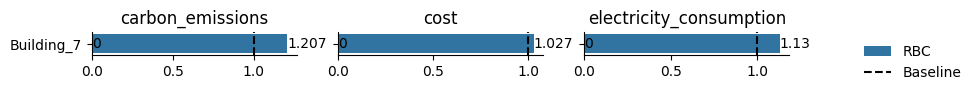

Building-level load profiles:


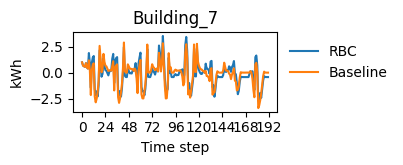

Battery SoC profiles:


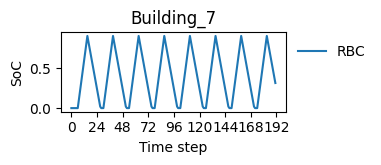

District-level KPIs:


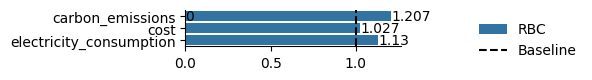

District-level load profiles:


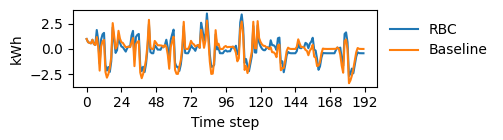

In [55]:
plot_simulation_summary(
    {'RBC': rbc_env}
)

In [ ]:
def get_loader(**kwargs):
    """Returns a progress bar with value display for episodes, timesteps, and elapsed time"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    progress_bar = IntProgress(**kwargs)
    episode_display = HTML(value='<b>Episode:</b> 1')  # Display for episode
    timestep_display = HTML(value='<b>Timestep:</b> 0')  # Display for timestep
    time_display = HTML(value='<b>Time Elapsed:</b> 00:00:00')  # Display for elapsed time
    time_per_episode_display = HTML(value='<b>Time Per Episode:</b> 00:00:00')  # Display for time per episode
    estimated_finish_display = HTML(value='<b>Estimated Finish:</b> Calculating...')  # Display for estimated finish time

    return VBox([progress_bar, episode_display, timestep_display, time_display, time_per_episode_display, estimated_finish_display])

In [ ]:
class CustomCallback(BaseCallback):
    def __init__(self, env: CityLearnEnv, loader: IntProgress):
        r"""Initialize CustomCallback.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        """

        super().__init__(verbose=0)
        self.loader = loader.children[0]  # Access the progress bar widget from the VBox
        self.episode_display = loader.children[1]  # Access the episode display widget from the VBox
        self.timestep_display = loader.children[2]  # Access the timestep display widget from the VBox
        self.time_display = loader.children[3]  # Access the time display widget from the VBox
        self.time_per_episode_display = loader.children[4]  # Access the time per episode display widget from the VBox
        self.estimated_finish_display = loader.children[5]  # Access the estimated finish time display widget from the VBox
        self.env = env
        self.timestep_per_episode = env.simulation_end_time_step - env.simulation_start_time_step
        self.reward_history = [0]
        self.start_time = time.time()
        self.episode_start_time = self.start_time
        self.episode_times = []
        self.max_episodes = self.loader.max/self.timestep_per_episode

    def _on_step(self) -> bool:
        r"""Called each time the env step function is called."""

        if self.env.time_step == 0:
            self.reward_history.append(0)
            self.episode_display.value = f'<b>Episode:</b> {len(self.reward_history)-1}'  # Update episode display
            if len(self.episode_times) > 0:
                average_time_per_episode = sum(self.episode_times) / len(self.episode_times)
                self.time_per_episode_display.value = f'<b>Time Per Episode:</b> {self.format_time_short(average_time_per_episode)}'
                episodes_remaining = self.max_episodes - len(self.episode_times)
                estimated_finish_time = self.episode_start_time + (average_time_per_episode * episodes_remaining)
                self.estimated_finish_display.value = f'<b>Estimated Finish:</b> {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(estimated_finish_time))}'

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])
            self.timestep_display.value = f'<b>Timestep:</b> {self.env.time_step}'  # Update timestep display

        self.loader.value += 1

        if self.env.time_step == (self.timestep_per_episode-1):
            episode_elapsed_time = time.time() - self.episode_start_time
            self.episode_times.append(episode_elapsed_time)
            self.episode_start_time = time.time()

        # Calculate and update elapsed time
        elapsed_time = time.time() - self.start_time
        self.time_display.value = f'<b>Time Elapsed:</b> {self.format_time(elapsed_time)}'

        return True

    def format_time(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f'{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}'

    def format_time_short(self, seconds):
        minutes, seconds = divmod(seconds, 60)
        return f'{int(minutes):02d}:{seconds:06.3f}'

In [ ]:
class CustomCityLearnEnv(CityLearnEnv):
    def __init__(self, schema):
        super(CustomCityLearnEnv, self).__init__(schema)
        for b in self.buildings:
            b.past_action = 0

    def step(self, action):
        observation, reward, done, info = super().step(action)
        for b,a in zip(self.buildings,action[0]):
            b.past_action = a

        return observation, reward, done, info

    def reset(self):
        initial_observation = super().reset()
        self.past_action = 0
        return initial_observation

In [ ]:
class CustomReward(RewardFunction):
    def __init__(self, env: CustomCityLearnEnv):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env: Mapping[str, CustomCityLearnEnv]
            Custom CityLearn environment instance.
        """

        super().__init__(env)

    def calculate(self) -> List[float]:
        r"""Returns reward for most recent action.

        Returns
        -------
        reward: List[float]
            Reward for transition to current timestep.
        """

        reward_list = []

        for b in self.env.buildings:
            # minimize the sum of cost and emissions
            cost = max(0,b.net_electricity_consumption_cost[-1])
            emission = max(0, b.net_electricity_consumption_emission[-1])
            charge = min(b.past_action * b.electrical_storage.capacity/b.electrical_storage.efficiency,
                         b.past_action * b.electrical_storage.capacity * b.electrical_storage.efficiency)
            if charge < 0:
                excess = -1 * min(0, charge + b.energy_from_electrical_storage[-1])
            else:
                excess = 1 * max(0, b.electrical_storage.soc[-2] + charge - b.electrical_storage.capacity)

            penalty = -1 * (cost + emission + excess)
            reward_list.append(penalty)

            # # custom reward from citylearn
            # cost = b.net_electricity_consumption_cost[-1]
            # battery_capacity = b.electrical_storage.capacity_history[0]
            # battery_soc = b.electrical_storage.soc[-1]/battery_capacity
            # penalty = -(1.0 + np.sign(cost)*battery_soc)
            # reward = penalty*abs(cost)
            # reward_list.append(reward)

        reward = [sum(reward_list)]

        return reward

In [ ]:
# ----------------- INITIALIZE ENVIRONMENT -----------------
sacr_env = CustomCityLearnEnv(schema)

# -------------------- SET CUSTOM REWARD -------------------
sacr_env.reward_function = CustomReward(sacr_env)

# -------------------- WRAP ENVIRONMENT --------------------
sacr_env = NormalizedObservationWrapper(sacr_env)
sacr_env = StableBaselines3Wrapper(sacr_env)

# -------------------- INITIALIZE AGENT --------------------
sacr_model = SAC(policy='MlpPolicy', env=sacr_env, seed=0)

# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
sac_episodes = 500
print('Number of episodes to train:', sac_episodes)
sac_episode_timesteps = sacr_env.time_steps - 1
sac_total_timesteps = sac_episodes*sac_episode_timesteps

# ----------------------- SET LOADER -----------------------
sac_modr_loader = get_loader(max=sac_total_timesteps)
display(sac_modr_loader)

# ----------------------- TRAIN AGENT ----------------------
sacr_callback = CustomCallback(env=sacr_env, loader=sac_modr_loader)
sacr_model = sacr_model.learn(
    total_timesteps=sac_total_timesteps,
    callback=sacr_callback
)

Number of episodes to train: 500


You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.


Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


Building-level KPIs:


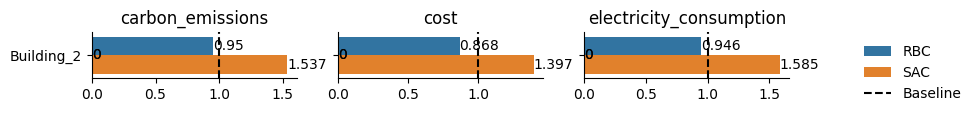

Building-level load profiles:


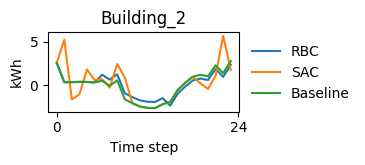

Battery SoC profiles:


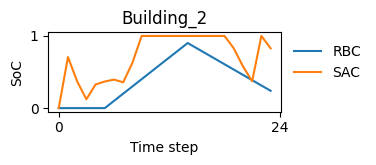

District-level KPIs:


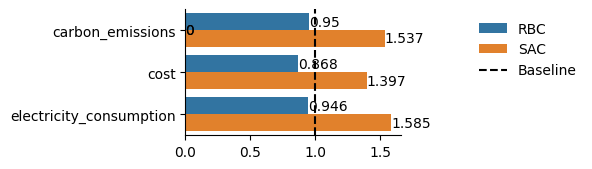

District-level load profiles:


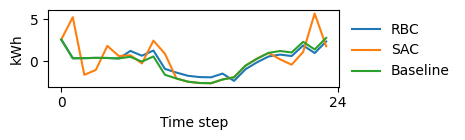

In [ ]:
sacr_env = CityLearnEnv(schema)
observations = sacr_env.reset()
sacr_actions_list = []
sacr_observations_list = []
sacr_unwrapped_observations_list = []

while not sacr_env.done:
    sacr_observations_list.append(observations)
    unwrapped_observations = np.array(sacr_env.unwrapped.observations[0])
    sacr_unwrapped_observations_list.append(unwrapped_observations)
    actions, _ = sacr_model.predict(observations, deterministic=True)
    observations, _, _, _ = sacr_env.step(actions)
    sacr_actions_list.append(actions)

plot_simulation_summary(
    {'RBC': rbc_env, 'SAC': sacr_env}
)

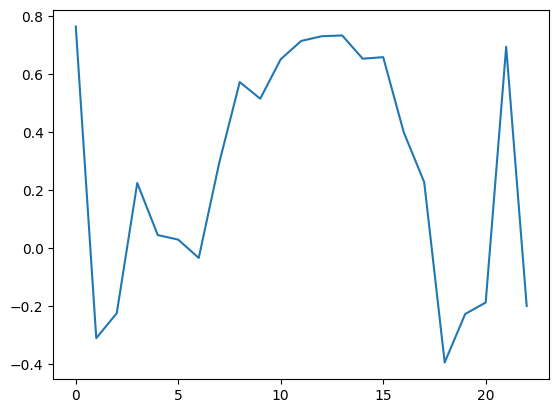

In [ ]:
plt.plot(np.array(sacr_actions_list).reshape(-1))

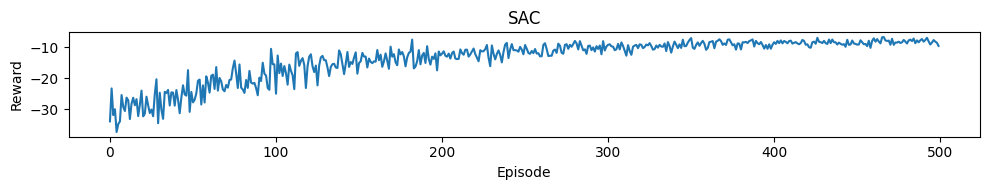

In [ ]:
rewards = {
    # 'SAC-1': sac_callback.reward_history[:sac_episodes],
    'SAC': sacr_callback.reward_history[:sac_episodes]
}
fig, axs = plt.subplots(1, 1, figsize=(10, 2))

for ax, (k, v) in zip(fig.axes, rewards.items()):
    ax = plot_rewards(ax, v, k)

plt.tight_layout()
plt.show()

In [ ]:
# display_array = [np.concatenate((np.repeat(a[:3],2),a[3:]),axis=0) for a in sacr_unwrapped_observations_list]

In [ ]:
feature_names = [
                #  'Month (cos)',
                #  'Month (sin)',
                #  'Weekday (cos)',
                #  'Weekday (sin)',
                #  'Hour (cos)',
                #  'Hour (sin)',
                #  'Diffuse Solar Irradiance',
                #  'Diffuse Solar Irradiance (6h Prediction)',
                #  'Diffuse Solar Irradiance (12h Prediction)',
                #  'Direct Solar Irradiance',
                #  'Direct Solar Irradiance (6h Prediction)',
                #  'Direct Solar Irradiance (12h Prediction)',
                 'Carbon Intensity',
                 'Home 2 Non Shiftable Load',
                 'Home 2 Solar Generation',
                 'Home 2 Electrical Storage SoC',
                 'Electricity Pricing',
                 'Electricity Pricing (6h Prediction)',
                 'Electricity Pricing (12h Prediction)',
                #  'Home 2 Non Shiftable Load',
                #  'Home 2 Solar Generation',
                #  'Home 2 Electrical Storage SoC',
                #  'Home 9 Non Shiftable Load',
                #  'Home 9 Solar Generation',
                #  'Home 9 Electrical Storage SoC',
                #  'Home 10 Non Shiftable Load',
                #  'Home 10 Solar Generation',
                #  'Home 10 Electrical Storage SoC',
                #  'Home 17 Non Shiftable Load',
                #  'Home 17 Solar Generation',
                #  'Home 17 Electrical Storage SoC',
                 ]

In [ ]:
display_df = pd.DataFrame(sacr_unwrapped_observations_list,columns=feature_names)

In [ ]:
sacr_observations_list = np.array(sacr_observations_list).reshape(23,-1)

In [ ]:
import shap

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
def f(X, n=0):
    y = []
    for i in X:
        y.append(sacr_model.predict(i, deterministic=True)[0][n])
    return np.array(y)

In [ ]:
explainer = shap.KernelExplainer(f, shap.sample(np.array(sacr_observations_list), 24))

In [ ]:
shap_values = explainer.shap_values(np.array(sacr_observations_list))

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
shap_df = pd.DataFrame(shap_values,columns=feature_names)

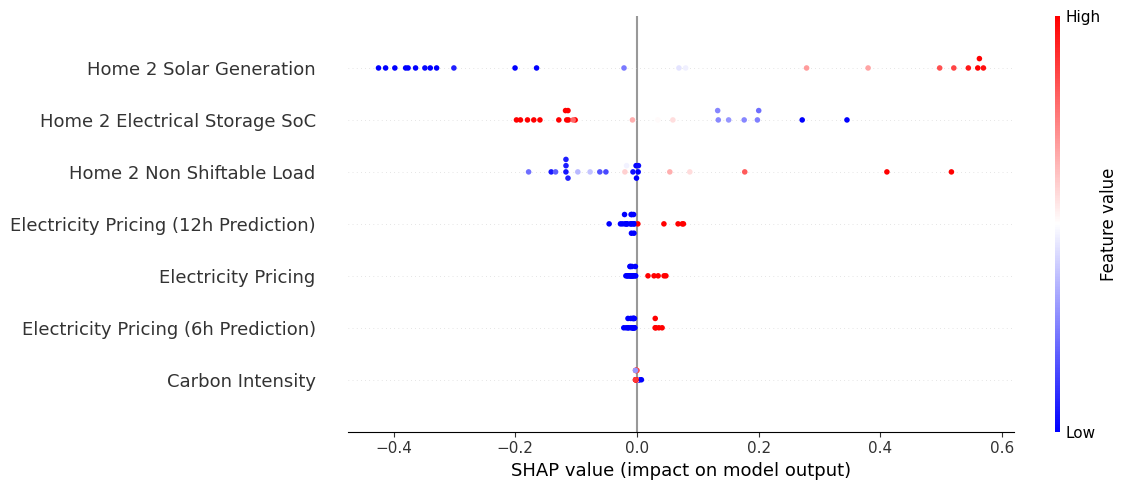

In [ ]:
shap.summary_plot(shap_values, features=np.array(sacr_observations_list), feature_names=feature_names, plot_size=(12.0,5.0), cmap='bwr')

In [ ]:
explanations = shap.Explanation(shap_values,explainer.expected_value, data=np.array(sacr_observations_list), display_data=display_df)

In [ ]:
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import colormaps
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm

In [ ]:
cmap = 'bwr'
norm = plt.Normalize(vmin=-0.2, vmax=0.2)

In [ ]:
plt.rcParams["font.size"] = 11
legend_loc = (1.07,1)
coord_loc = (-0.05,0.5)
x_range = range(0,len(shap_values[:,0]))
weekdays = ['Mon',]
bldg_idx = [7]
# 'Tue','Wed','Thu','Fri','Sat','Sun'

In [ ]:
np.array(sacr_actions_list).reshape(-1)

array([ 0.7647995 , -0.31076717, -0.22467291,  0.22450829,  0.04510099,
        0.02911037, -0.03399342,  0.294528  ,  0.5729469 ,  0.51549375,
        0.6518009 ,  0.7149582 ,  0.7311704 ,  0.7338258 ,  0.6535741 ,
        0.6588874 ,  0.40007424,  0.22760952, -0.3947196 , -0.22736293,
       -0.1878621 ,  0.694829  , -0.19979829], dtype=float32)

In [ ]:
action_list = np.array(sacr_actions_list).reshape(-1)
charge = [action_list[0] if action_list[0]>0 else None]
discharge = [action_list[0] if action_list[0]<0 else None]
timestep = [0.0]

for i, a in enumerate(action_list[1:]):
    if a<0 and action_list[i]<0:
        charge.append(None)
        discharge.append(a)
        timestep.append(float(i+1))
    elif a>0 and action_list[i]>0:
        charge.append(a)
        discharge.append(None)
        timestep.append(float(i+1))
    elif a<0 and action_list[i]>0:
        charge.append(0.0)
        charge.append(None)
        discharge.append(0.0)
        discharge.append(a)
        timestep.append(np.interp(0,[-1*action_list[i],-1*a], [i,i+1]))
        timestep.append(float(i+1))
    elif a>0 and action_list[i]<0:
        charge.append(0.0)
        charge.append(a)
        discharge.append(0.0)
        discharge.append(None)
        timestep.append(np.interp(0,[action_list[i],a], [i,i+1]))
        timestep.append(float(i+1))

In [ ]:
def baseplot(subplots, size = (20,12)):
    fig = plt.figure(figsize=size)
    gs = fig.add_gridspec(subplots, hspace=0.25)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].set_xticks(np.arange(0, 24, 24))
    axs[0].set_xticklabels(weekdays)
    axs[0].plot(display_df['Home 2 Non Shiftable Load'], label="Load", color="dimgray")
    axs[0].plot(display_df['Home 2 Solar Generation'], label="Generation", color="orange")
    axs[0].set_ylabel('Home 2\nElectrical\nEnergy\n[kWh]')
    axs[0].legend(loc='upper left', bbox_to_anchor=legend_loc, frameon=False)
    axs[0].set_yticks(np.arange(0,6,2.5))
    axs[0].get_yaxis().set_label_coords(*coord_loc)
    axs[1].plot(range(0,len(action_list)),action_list)
    axs[1].plot(timestep, charge, color="red", label="Charging",zorder=10)
    axs[1].plot(timestep,discharge, color="blue", label="Discharging",zorder=10)
    axs[1].set_zorder(1)
    axs[1].patch.set_visible(False)
    axs[1].set_ylim((-1.1,1.1))
    axs[1].set_yticks(np.arange(-1.0,1.5,1.0))
    axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[1].set_ylabel('Home 2\nCharge\nRate\n[-]')
    axs[1].get_yaxis().set_label_coords(*coord_loc)
    ax2 = axs[1].twinx()
    ax2.fill_between(range(0,len(action_list)),np.zeros(action_list.shape),display_df['Home 2 Electrical Storage SoC'], color="green", alpha=0.2, zorder=0, label="SoC")
    ax2.set_ylim((-0.1,1.1))
    ax2.set_yticks([0,0.5,1])
    ax2.set_ylabel('Battery\nSoC')
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[1].legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=legend_loc, frameon=False)
    return fig, axs

In [ ]:
def shap_scatter(feature, label, shap_idx, plot_idx, ax):
    ax[plot_idx].scatter(x_range, display_df[feature], c=shap_values[:,shap_idx], cmap=cmap, norm=norm)
    ax[plot_idx].plot(display_df[feature], c='gray', linestyle=":")
    ax[plot_idx].set_ylabel(label)
    ax[plot_idx].get_yaxis().set_label_coords(*coord_loc)

In [ ]:
def shap_colorbar(fig, axs, left=0.95, width=0.01, scale=2):
    height = (axs[2].get_position().y1-axs[2].get_position().y0)*scale
    mid = (axs[2].get_position().y1 + axs[-1].get_position().y0)/2
    bottom = mid - height/2
    cbar_ax = fig.add_axes([left, bottom, width, height])
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=cbar_ax)
    label_range = np.linspace(norm.vmin, norm.vmax, 5)
    labels = ["{:.1f} Discharging","{:.1f}", " {:.1f}", " {:.1f}"," {:.1f} Charging"]
    cb.ax.set_yticks(label_range)
    cb.ax.set_yticklabels([l.format(r) for l,r in zip(labels, label_range)])
    cb.set_label("SHAP values", labelpad=-120)
    return cb

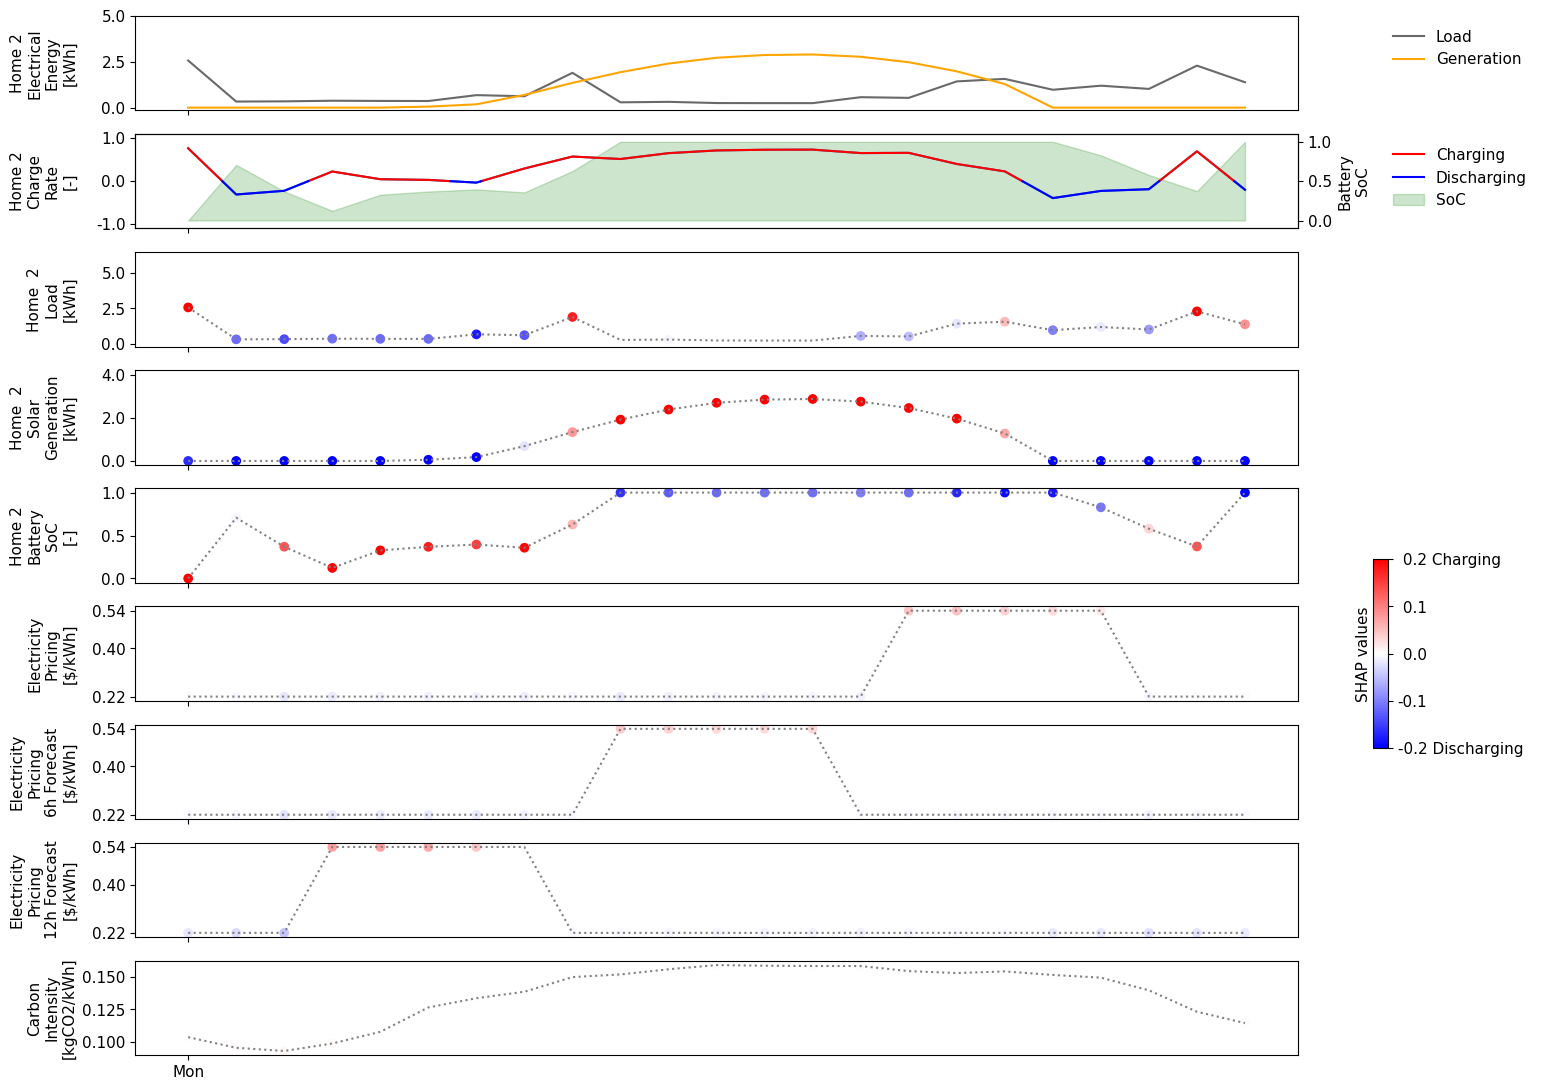

In [ ]:
b = 2
fig, axs = baseplot(9, size = (15,9*1.5))
colorbar = shap_colorbar(fig, axs)
shap_scatter(f'Home {b} Non Shiftable Load', f"Home  {b}\nLoad\n[kWh]", 1, 2, axs)
axs[2].set_ylim((-0.17328, 6.43888))
axs[2].set_yticks(np.arange(0.0,6.0,2.5))
shap_scatter(f'Home {b} Solar Generation', f"Home  {b}\nSolar\nGeneration\n[kWh]", 2, 3, axs)
axs[3].set_ylim((-0.17328, 4.23888))
axs[3].set_yticks(np.arange(0.0,5.0,2))
axs[3].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
shap_scatter(f'Home {b} Electrical Storage SoC', f"Home {b}\nBattery\nSoC\n[-]", 3, 4, axs)
axs[4].set_yticks(np.arange(0.0,1.5,0.5))
shap_scatter('Electricity Pricing', "Electricity\nPricing\n[$/kWh]", 4, 5, axs)
axs[5].set_yticks([0.22, 0.40 ,0.54])
shap_scatter('Electricity Pricing (6h Prediction)', "Electricity\nPricing\n6h Forecast\n[$/kWh]", 5, 6, axs)
axs[6].set_yticks([0.22, 0.40 ,0.54])
shap_scatter('Electricity Pricing (12h Prediction)', "Electricity\nPricing\n12h Forecast\n[$/kWh]", 6, 7, axs)
axs[7].set_yticks([0.22, 0.40 ,0.54])
shap_scatter('Carbon Intensity', "Carbon\nIntensity\n[kgCO2/kWh]", 0, 8, axs)

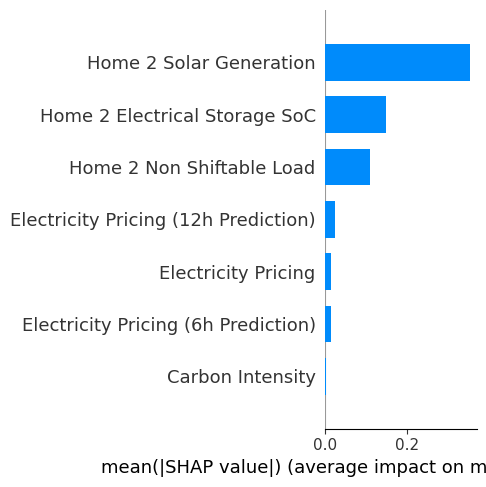

In [ ]:
shap.summary_plot(shap_values, features=np.array(sacr_observations_list), feature_names=feature_names, plot_size=(5,5), cmap='bwr', plot_type='bar')

In [ ]:
# from google.colab import runtime
# runtime.unassign()